# Originality analysis of an author


## Scraping Lakshmi Sankaran's Author page for links to articles

In [320]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from webdriver_manager.chrome import ChromeDriverManager

In [321]:
url = r'https://natgeotraveller.in/author/lakshmi-sankaran/'
driver = webdriver.Chrome(ChromeDriverManager().install())

In [322]:
driver.get(url) 

**Before executing the next cell please make sure you have clicked the 'load more' button in the webpage until all the aritcles are loaded**

Otherwise only the articles shown in the beginning will be scraped. Automating clicking of the 'load more' button is a TODO item

In [323]:
soup = BeautifulSoup(driver.page_source,'html.parser')
all_posts_div = soup.find(id='articlePostByAuthor')
posts_elements = all_posts_div.find_all("div", {"class": "similar-article-box"})

In [324]:
posts_links= [elem.find('a')['href'] for elem in posts_elements]
print(len(posts))
posts_links[:5]

29


['http://natgeotraveller.in/latest-in-travel-flights-from-pune-to-singapore-quarantine-free-travel-to-taiwan-and-more/',
 'http://natgeotraveller.in/latest-in-travel-schengen-digital-visa-for-smoother-eu-trips/',
 'http://natgeotraveller.in/a-culture-ride-through-chiang-mai-and-chiang-rai/',
 'http://natgeotraveller.in/splendour-at-sea/',
 'http://natgeotraveller.in/in-thailand-nostalgia-on-wheels/']

_posts\_links_ contains links to all 29 posts by our target author

## Scraping the content from each of the articles

In [325]:
to_remove = ['\xa0','***']
subscribe_lines = ['To read more stories on travel, cities, food, nature, and adventure',
                   'To\xa0subscribe\xa0to\xa0National Geographic Traveller']
def get_article_text(link):
    driver.get(link)
    soup = BeautifulSoup(driver.page_source,'html.parser').select(".blog-cont")[0]
    div = BeautifulSoup(str(soup),'html.parser')
    text = [i.text for i in div.select("p:not(.vital *):not(.wp-caption-text)")]
    for i in to_remove:
        while True:
            try:
                text.remove(i)
            except ValueError:
                break
    for i in subscribe_lines:
        if(text[-1].startswith(i)):
            del text[-1]
            break
    return " ".join(text)

In [326]:
all_articles = [get_article_text(link) for link in posts_links]

In [218]:
len(all_articles)

29

_all\_articles_ now contains the text of all the 29 articles by our target author

## Creating the vectorizer and calculating the similarity between articles

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [236]:
vectorizer = TfidfVectorizer(binary=True)

In [334]:
vectorizer.fit(all_articles)

TfidfVectorizer(binary=True)

In [340]:
vectorize = lambda text: vectorizer.transform([text]).toarray()
similarity = lambda vec1, vec2: cosine_similarity(vec1, vec2)[0][0]

In [341]:
vectors = [vectorize(text) for text in all_articles]

In [290]:
num_articles = len(all_articles)
similarity_matrix = [[0 for i in range(num_articles)] for k in range(num_articles)]
for i in range(num_articles):
    for j in range(num_articles):
        similarity_matrix[i][j] = similarity(vectors[i],vectors[j])

In [347]:
sum = 0
for i in range(num_articles):
    for j in range(num_articles):
        if i!=j: sum+=similarity_matrix[i][j]
print("Average similarity =", sum/(num_articles**2-num_articles))

Average similarity = 0.06901716690057633


## Plotting the similarity matrix

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: title={'center': 'Similarity between each articles'}>

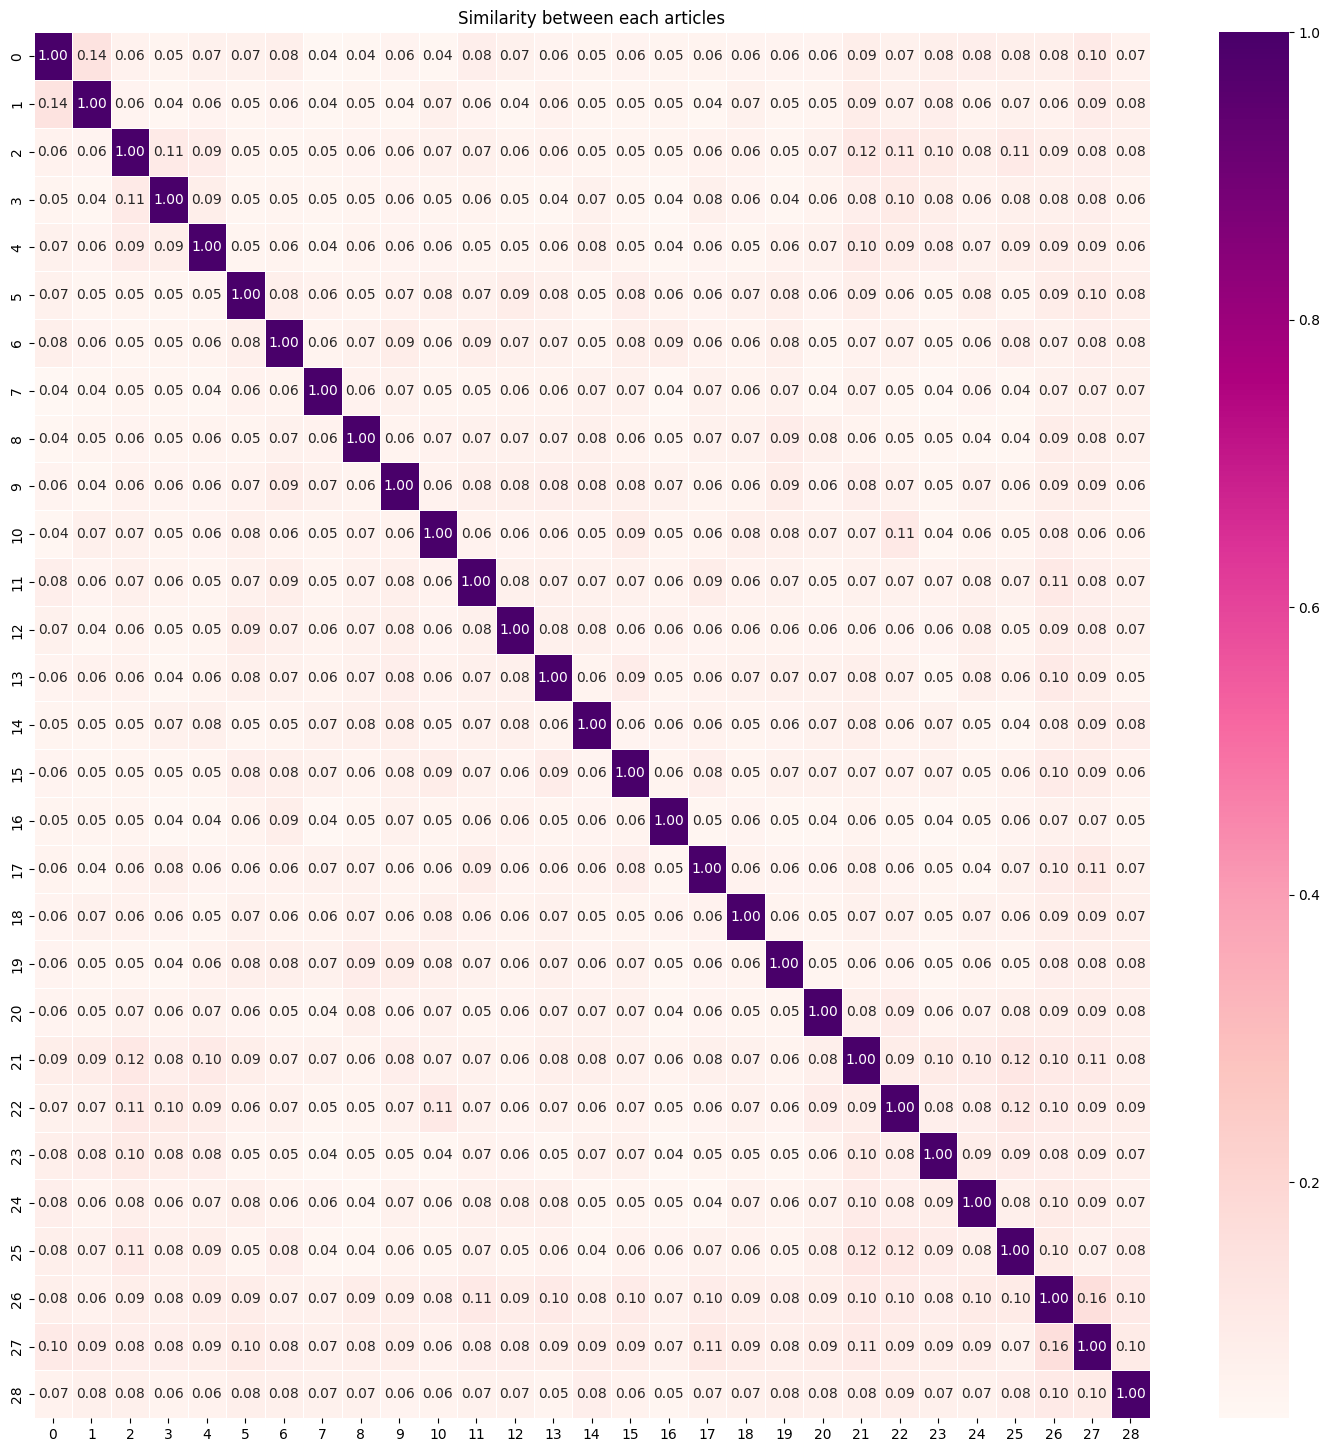

In [362]:
fig, ax = plt.subplots(figsize=(18,18)) 
plt.title('Similarity between each articles')
sns.heatmap(similarity_matrix, annot=True,fmt=".2f",cmap="RdPu", linewidths=0.5)

## Similarity of each article to combination of rest of all writings

In [363]:
sim_to_rest = []
for i in range(num_articles):
    total_text = ""
    for j in range(num_articles):
        if(i!=j): total_text+=all_articles[j]
    total_vector = vectorize(total_text)
    sim_to_rest.append(similarity(vectors[i],total_vector))

In [360]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [354]:
df = pd.DataFrame()

In [356]:
df['links'] = posts_links

In [358]:
df['sim_to_rest'] = sim_to_rest

In [361]:
df

,links,sim_to_rest
0,http://natgeotraveller.in/latest-in-travel-flights-from-pune-to-singapore-quarantine-free-travel-to-taiwan-and-more/,0.095879
1,http://natgeotraveller.in/latest-in-travel-schengen-digital-visa-for-smoother-eu-trips/,0.106737
2,http://natgeotraveller.in/a-culture-ride-through-chiang-mai-and-chiang-rai/,0.152848
3,http://natgeotraveller.in/splendour-at-sea/,0.112238
4,http://natgeotraveller.in/in-thailand-nostalgia-on-wheels/,0.117495
5,http://natgeotraveller.in/a-citys-state-of-mind/,0.090506
6,http://natgeotraveller.in/the-great-outdoors-may-not-be-great-for-long/,0.098393
7,http://natgeotraveller.in/searching-for-our-pop-culture-gods/,0.075520
8,http://natgeotraveller.in/a-bombay-classic-that-endures/,0.095880
9,http://natgeotraveller.in/redefining-goals/,0.089706


In [364]:
df['sim_to_rest'].mean()

0.10498212272569266

## Conclusion
The average similarity between each article in 7% 
The average similarity between eact article to all the other writings is about 10%

This is a fairly acceptable amount of similarity considering that stop words have not been removed